# Projet: Traitement des données distribuées
## Paul Graffan

# Subject description
For this project I decided to use pyspark in order to analyse graph data. I have chosen the **High-energy physics theory citation network** dataset available at: https://snap.stanford.edu/data/cit-HepTh.html.

This dataset represent a graph of citations between scientific 27770 papers. A bigger dataset of this type is also available but since I work in local I decided to use the smaller one.

In this project I will use pyspark and GraphFrames to manipulate data. First, we will manipulate data from the file of citations and the files of metadatas in order to create a dataframe from ou graph. This will allow us to obtain a ranking of papers according to the number of citations received. Then, I will apply  PageRank algorithm to have another ranking of papers and compare both rankings. Further on, I will cluster papers using Label Propagation Algorithm and try to described the obtained clusters. Finally, I propose a visualization of the graph of papers.

I chose to work with graph structured data because it is well suited for distributed application. Indeed, with social network and the web graph can be incredibly large in size. This project was the opportunity to learn how to work with them and apply unsipervised algorithm to extract informations from it.

In [1]:
import os

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import *

In [2]:
sns.set()

In [3]:
conf = pyspark.SparkConf().setAll([('spark.executor.memory', '4g'), ('spark.executor.cores', '2'), ('spark.cores.max', '2'), ('spark.driver.memory','4g')])
sc = pyspark.SparkContext(conf=conf)

In [4]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

# Create dataframe of citations

The file 'cit-HepTh.txt' contains the edges of citations structured as follow: <br>
- Id_paper_from, Id_paper_to

In [5]:
spark = SparkSession(sc)

In [179]:
lines = sc.textFile('data/cit-HepTh.txt')

In [7]:
lines.take(1)

['1001\t9304045']

In [8]:
lines.getNumPartitions()

2

## Structure as follow: (id_paper, [citations_given], nb_citations_given)



In [9]:
citations_given_by_paper = lines.map(lambda x: (x.split('\t')[0], [x.split('\t')[1]]))\
                                .reduceByKey(lambda a,b: a+b)

In [11]:
citations_given_by_paper.take(1)

[('9311042', ['9301042', '9301043'])]

In [12]:
citations_given_by_paper.count()

25059

As dataframe

In [13]:
citations_given_by_paper = citations_given_by_paper.map(lambda x: (x[0], x[1], len(x[1]))).toDF(['id', 'cit_given', 'nb_cit_given'])

In [13]:
citations_given_by_paper.show(2)

+-------+--------------------+------------+
|     id|           cit_given|nb_cit_given|
+-------+--------------------+------------+
|9311042|  [9301042, 9301043]|           2|
|9401139|[9201015, 9201040...|          40|
+-------+--------------------+------------+
only showing top 2 rows



## Structure as follow:  (id_paper, [citations_received], nb_citations_received)

In [14]:
citations_received_by_paper =  lines.map(lambda x: (x.split('\t')[1], [x.split('\t')[0]]))\
                                .reduceByKey(lambda a,b: a+b)

In [16]:
citations_received_by_paper.take(1)

[('9311042',
  ['1001',
   '9510234',
   '9511171',
   '9601108',
   '9602114',
   '9702155',
   '9905036',
   '1025',
   '9507012',
   '9807087',
   '9906200',
   '9706110',
   '9705131',
   '9906242',
   '9903166',
   '9608024',
   '9704151',
   '9711124',
   '9610162',
   '2004',
   '9409110',
   '9906046',
   '9712223',
   '9610251',
   '9412236',
   '9711090',
   '9604043',
   '3263',
   '9801022',
   '9608039',
   '9411131',
   '9601014',
   '9412115',
   '9808192',
   '7243',
   '9042',
   '9072',
   '11059',
   '11101',
   '9605154',
   '12041',
   '102133',
   '102198',
   '104254',
   '107217',
   '108229',
   '109164',
   '111113',
   '203111',
   '209161',
   '209230',
   '210231',
   '9608104',
   '9601179',
   '9612075'])]

In [17]:
citations_received_by_paper.count()

23180

As dataFrame

In [15]:
citations_received_by_paper = citations_received_by_paper.map(lambda x: (x[0], x[1], len(x[1]))).toDF(['id', 'cit_received', 'nb_cit_received'])

In [13]:
citations_received_by_paper.show(2)

+-------+--------------------+---------------+
|     id|        cit_received|nb_cit_received|
+-------+--------------------+---------------+
|9311042|[1001, 9510234, 9...|             55|
|9401139|[1001, 9407087, 9...|            421|
+-------+--------------------+---------------+
only showing top 2 rows



In [21]:
citations_received_by_paper.count()

23180

### Join both rdd to get: (id_paper, [citations_given], nb_given, [citations_received], nb_received)

We use a full join to keep papers that never gave citation or haven't been cited. Full join will keeps lines with no matching keys and fill the missing values by null.

In [16]:
df_citations = citations_given_by_paper.join(citations_received_by_paper, ['id'], how='full')

In [24]:
df_citations.show(2)

+------+--------------------+------------+--------------------+---------------+
|    id|           cit_given|nb_cit_given|        cit_received|nb_cit_received|
+------+--------------------+------------+--------------------+---------------+
| 10096|[5092, 9207001, 9...|          14|[102116, 105286, ...|              9|
|101021|[12162, 9406081, ...|          10|            [104033]|              1|
+------+--------------------+------------+--------------------+---------------+
only showing top 2 rows



In [25]:
df_citations.count()

27770

We find the total number of papers given on with the informations of the dataset.

## Join metadata 

### Title and Abstract

In this part we will extract the title, abstract and year of publication of the papers using the metadata file.
<br><br>
The metadata is organized as follow: there is one root directory containing sub-directories corresponding at each year from 1992 to 2003. Each sub-directory contains one txt file per paper written that year.
<br><br>
In order to extract the wanted informations, the function extract_paperidAndTitle will populate a 2D array with each line containing the informations of 1 paper.

In [17]:
def extract_paperidAndTitle(rootdir):
    res = []
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            f = open(os.path.join(subdir, file),'r')
            text = ''
            for line in f.readlines():
                text += line
            
            intermediate_res = []
            for t in text.replace('\n', '--').split('\\\\')[1].split('--'):
                if t.startswith('Paper:'):
                    intermediate_res.append(t.replace(',', '').split('/')[-1])
                if t.startswith('Title:'):
                    intermediate_res.append(t.replace('Title: ', ''))
            intermediate_res.append(text.replace('\n', ' ').replace(',', '').split('\\\\')[2])
            intermediate_res.append(subdir.split('/')[-1])
            res.append(intermediate_res)
    return res

In [18]:
infos = extract_paperidAndTitle('cit-HepTh-abstracts')

In [28]:
len(infos)

29555

In [29]:
infos[4]

['9210088',
 'A Conformal Affine Toda Model of 2D Black Holes: A Quantum Study of the',
 '   In this paper we reformulate the dilaton-gravity theory of Callan \\etal\\ as a new effective conformal field theory which turns out to be a generalization of the so-called $SL_2$-conformal affine Toda (CAT) theory studied some times ago by Babelon and Bonora. We quantize this model thus keeping in account the dilaton-gravity quantum effects. We then implement a Renormalization Group analysis to study the black hole thermodynamics and the final state of the Hawking evaporation. ',
 '1992']

In [19]:
df_metadata = sc.parallelize(infos).map(lambda x: [x[0], x[1], x[2], x[3]]).toDF(['id', 'title', 'abstract', 'year'])

In [20]:
del infos

In [24]:
df_metadata.show(3)

+-------+--------------------+--------------------+----+
|     id|               title|            abstract|year|
+-------+--------------------+--------------------+----+
|9204042|Asymptotic Behavi...|   We consider th...|1992|
|9204020|Symplectic fusion...|   The fusion of ...|1992|
|9211110|Low-Energy Effect...|   A fundamental ...|1992|
+-------+--------------------+--------------------+----+
only showing top 3 rows



In [25]:
df_metadata.count()

29555

### Date of publication

We will now retreive the date of publication of each article contained in 'cit-HepTh-dates.txt'.<br>
<br>
<span style="color:red">Note that crosslisted paper have an id starting with 11. We will ignore lines with such ids. Also, in the file of dates, all id have 7 digits. This means that ids with less that 7 digits in the graph file have been filled with 0s. We will need to correct that in order for ids to match. The latter statement is true for metadata as well. </span>

In [21]:
dates = sc.textFile('data/cit-HepTh-dates.txt')

In [22]:
dates = dates.map(lambda x: (x.split('\t')[0], x.split('\t')[1]))

In [23]:
df_dates = dates.toDF(['id', 'date'])

In [29]:
df_dates.show(3)

+-------+----------+
|     id|      date|
+-------+----------+
|9203201|1992-02-24|
|9203202|1992-03-08|
|9203203|1992-03-03|
+-------+----------+
only showing top 3 rows



In [44]:
print(df_dates.count())
print(df_dates.rdd.getNumPartitions())

38557
2


We can see that their is more lines that in the total number of papers

Putting date to date format

In [24]:
df_dates = df_dates.withColumn('date',F.to_date("date", "yyyy-MM-dd"))

In [31]:
df_dates.show(3)

+-------+----------+
|     id|      date|
+-------+----------+
|9203201|1992-02-24|
|9203202|1992-03-08|
|9203203|1992-03-03|
+-------+----------+
only showing top 3 rows



In [25]:
from pyspark.sql.window import Window

We group by id and order by dates, then we only pick the first line of each group. The idea is to check if there is multiple lines with the same ids.

In [33]:
window = Window.partitionBy(df_dates['id']).orderBy(df_dates['date'].desc())

In [34]:
df_dates.select('*', F.rank().over(window).alias('rank')).filter(F.col('rank') <= 1).count() 

37674

It seems that some lines have the same id with different dates but there is still more lines than the total number of papers.

In [50]:
df_dates.rdd.map(lambda x:(x[0],1)).reduceByKey(lambda x,y: 1).count()

37621

Since it appears that there is more papers in the date file than it the graph file, we will use a left join on df_citations to only keep lines originaly in df_citations. 

In [25]:
df_dates = df_dates.dropDuplicates(['id'])

### Joining it all together

#### Using User defined function UDF

To put ids to the same format we will use a UDF.

In [26]:
def format_id(_id):
    if len(_id) < 7:
        return '0'*(7-len(_id)) + _id
    else:
        return _id
    
#Ex : UDF_format_id('5027') = '0005027'

In [27]:
format_id_udf = F.udf(format_id, StringType())

In [28]:
df_citations_2 = df_citations

In [29]:
df_citations_2 = df_citations_2.withColumn("id", format_id_udf(df_citations_2["id"]))

#### Performing join

In [30]:
df_citations_2 = df_citations_2.join(df_metadata, ['id'], how='left')

In [32]:
df_citations_2.where(F.col('Title').isNotNull()).count()

27770

In [31]:
df_citations_2 = df_citations_2.join(df_dates, ['id'], how='left')

In [43]:
df_citations_2.show(2)

+-------+--------------------+------------+------------+---------------+--------------------+--------------------+----+----------+
|     id|           cit_given|nb_cit_given|cit_received|nb_cit_received|               title|            abstract|year|      date|
+-------+--------------------+------------+------------+---------------+--------------------+--------------------+----+----------+
|0001147|           [9411102]|           1|        null|           null|U(1) Connection, ...|   By analysing t...|2000|2000-01-17|
|0002249|[2106, 2172, 9711...|          13|        null|           null|AdS/CFT Correspon...|   We review some...|2000|2000-02-24|
+-------+--------------------+------------+------------+---------------+--------------------+--------------------+----+----------+
only showing top 2 rows



In [44]:
df_citations_2.where(F.col('date').isNotNull()).count()

8326

In [45]:
df_citations_2.count()

27770

In [35]:
df_citations_2.rdd.getNumPartitions()

200

In [37]:
df_citations_2.rdd.getNumPartitions()

2

Fixing the id solved all problems of matching for the metadata but not for the dates. Since we don't have all exact publishing dates, we might only refer to the year of publication obtained with metadata.

### Filling null values

In [32]:
df_citations_2 = df_citations_2.na.fill({'nb_cit_given':'0', 'nb_cit_received':'0'})

# Exploratory Data Analysis

## Most cited papers

We will first analyse the top 10 most cited scientific papers.

In [39]:
top_10_papers = df_citations_2.sort(F.col("nb_cit_received").desc()).limit(10).toPandas()

In [40]:
top_10_papers

,id,cit_given,nb_cit_given,cit_received,nb_cit_received,title,abstract,year,date
0,9711200,"[9204099, 9209116, 9307049, 9508072, 9510134, ...",54,"[9908144, 9809015, 9810063, 9812035, 9902125, ...",2414,The Large N Limit of Superconformal Field Theo...,We show that the large $N$ limit of certain...,1997,None
1,9802150,"[9308075, 9409089, 9410073, 9602135, 9610043, ...",22,"[9810063, 9812035, 9902125, 9902155, 9904017, ...",1775,Anti De Sitter Space And Holography,Recently it has been proposed by Maldacena ...,1998,None
2,9802109,"[9510017, 9510135, 9602135, 9605009, 9702076, ...",12,"[9810063, 9812035, 9902125, 9902155, 9904017, ...",1641,Gauge Theory Correlators from Non-Critical Str...,We suggest a means of obtaining certain Gre...,1998,None
3,9407087,"[9204102, 9211097, 9401139, 9402002, 9402005, ...",9,"[1001, 9408099, 9501030, 9503124, 9504090, 950...",1299,"Monopole Condensation, And Confinement In N=2 ...",We study the vacuum structure and dyon spec...,1994,None
4,9610043,"[9308139, 9405069, 9409089, 9410167, 9501068, ...",19,"[9707014, 9707042, 1011, 9612115, 9703038, 970...",1199,M Theory As A Matrix Model: A Conjecture,We suggest and motivate a precise equivalen...,1996,None
5,9510017,"[208020, 9403040, 9407031, 9410167, 9503124, 9...",10,"[9511030, 9602022, 9603167, 9605184, 9609239, ...",1155,Dirichlet-Branes and Ramond-Ramond Charges,We show that Dirichlet-branes extended obje...,1995,None
6,9908142,"[9207011, 9305139, 9309028, 9403050, 9511030, ...",75,"[9909229, 1011, 9909081, 9909176, 1027, 991000...",1144,String Theory and Noncommutative Geometry,We extend earlier ideas about the appearanc...,1999,None
7,9503124,"[9205027, 9401139, 9402002, 9406012, 9407087, ...",10,"[1001, 9505025, 9505054, 9505105, 9505162, 950...",1114,String Theory Dynamics In Various Dimensions,The strong coupling dynamics of string theo...,1995,None
8,9906064,"[9604090, 9711200, 9805157, 9809147, 9905111, ...",6,"[1002, 9907209, 9908076, 9908116, 9908186, 990...",1032,An Alternative to Compactification,Conventional wisdom states that Newton's fo...,1999,None
9,9408099,"[9204102, 9211097, 9402002, 9402005, 9402044, ...",7,"[1001, 9501030, 9505105, 9505162, 9506112, 950...",1006,"Monopoles, Duality and Chiral Symmetry Breakin...",We study four dimensional $N=2$ supersymmet...,1994,None


## Number of citations given/received per year

In [41]:
df_citations_2 = df_citations_2.withColumn("nb_cit_given", df_citations_2.nb_cit_given.cast(IntegerType()))
df_citations_2 = df_citations_2.withColumn("nb_cit_received", df_citations_2.nb_cit_received.cast(IntegerType()))

In [42]:
year_cit_given  =  df_citations_2.groupBy('year').avg('nb_cit_given').orderBy('year').toPandas()

In [43]:
year_cit_received = df_citations_2.groupBy('year').avg('nb_cit_received').orderBy('year').toPandas()

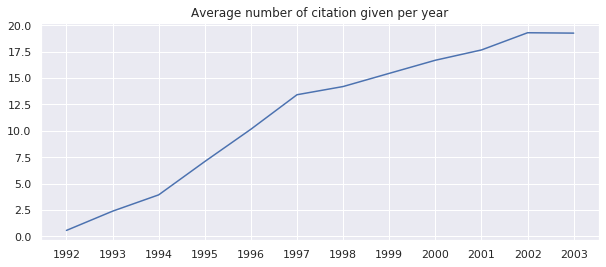

In [44]:
fig= plt.figure(figsize=(10,4))
plt.plot(year_cit_given['year'], year_cit_given['avg(nb_cit_given)'])
plt.title('Average number of citation given per year')
plt.show()

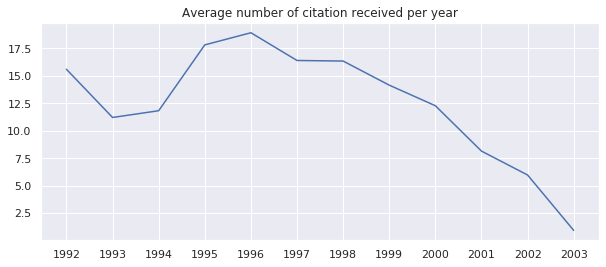

In [53]:
fig= plt.figure(figsize=(10,4))
plt.plot(year_cit_received['year'], year_cit_received['avg(nb_cit_received)'])
plt.title('Average number of citation received per year')
plt.show()

As expected, the average number of citations received decreases with time. Naturaly, older paper have more "time" to be cited in future papers. This result, even though beeing intuitive is quiet interesting. Indeed, when we will apply PageRank algorithm to our networks, we will take into account that older papers are naturally higher ranked that newer one. In fact, we can see that comparing paper from after 1998 with the others would not make much sense.
<br><br>
Another interesting pattern on the above graph is that there is a pike of publications received between 1995 and 1997. Maybe there has been a major breakthrough in physics during those year. 

## Page Rank

Ranking articles by number of citations received is interesting but it has a bias. Indeed, this way of ranking does not count the importance fo the citing papers (being cited by an obscure paper has the same importance than being cited by a gound-breaking one). In order to reduce this bias the PageRank algorithm gives higher weights to publications that are highly cited. PageRank algorithm gives another ranking that should better capture the true importance of a paper.
<br>
<br>
### What is PageRank algorithm ?
We will now dive further into the PageRank algorithm, we introduce the notation:

- $p_{1}...p_{n}$: a collection of n papers
- $PR(p)$: (PageRank) the actual page rank of a paper
- $T^{p}_{1},...,T^{p}_{n}$: the collection of article citing paper p
- $C(p)$: the number of paper cited by p
- $d \in (0,1)$: the damping factor

We can now wright the formula to calculate the PageRank of paper p:
<p style="text-align: center;">
$PR(p)=(1-d)+d(\sum_{i=1}^{n} \frac{PR(T^{p}_{i})}{C(T^{p}_{i})})$
</p>
The PageRank of a graph of documents can then be calculated iteratively using this from initialized PageRanks.<br>
To explain a little further, $PR(PR(T^{p}_{i}))$ means that each paper has a notion of it's own importance, and $\frac{PR(T^{p}_{i})}{C(T^{p}_{i})}$ means that each paper distributes its importance evenly between all papers it cites. The damping factor $d$ represent the probability of a random reader (called random surfer in the original paper) to read a paper cited in the paper he is currently reading, and $1-d$ represent the probability to read another paper picked randomly. In other words, if their is a closed loop of citations, a reader would not stay stuck into it. Note that different values of $d$ yields different ranking. For simplicity we will keep the original value of $d=0.85$ but PageRank as a Function of the Damping Factor is a good paper on the topic.
<br><br>
    

### Implementation
In our first implementation of page rank, we will the rdd of our graph of given citations.

In [54]:
pagerank_rdd = lines.map(lambda x: (x.split('\t')[0], x.split('\t')[1]))\
                                .groupByKey()

In [55]:
pagerank_rdd.take(1)

[('9311042', <pyspark.resultiterable.ResultIterable at 0x7fcbc782d5c0>)]

We initialize ranks to 1

In [56]:
ranks = pagerank_rdd.mapValues(lambda x: 1)

In [18]:
ranks.take(1)

[('9311042', 1)]

We define compute_contribs, a funtion that computes $C(p)$ for each paper.

In [57]:
def compute_contribs(papers, rank):
    for p in papers:
        yield (p, rank/len(papers))

In [59]:
for i in range(20):
    contribs = pagerank_rdd.join(ranks).values().flatMap(lambda x: compute_contribs(x[0], x[1]))
    ranks = contribs.reduceByKey(lambda x,y: x+y).mapValues(lambda x: 0.15+0.85*x)

In [60]:
ranks.take(10)

[('9301042', 17.030329641530724),
 ('9301043', 7.3170185810930315),
 ('9201040', 5.655035088418202),
 ('9202046', 7.856900928724709),
 ('9202059', 3.659253519512172),
 ('9202092', 4.881035994501191),
 ('9203008', 1.487006212213638),
 ('9204035', 3.8681167679729516),
 ('9204040', 1.4734299196147413),
 ('9205046', 3.072105563995807)]

In [61]:
ranks.count()

18028

We only have 18028 ranks instead of the 27770 papers initially present in the citation graph. This is because of the way our PageRank is implemented.
<br><br>
Let's analyse our implementation of PageRank:

- Step 1: we generate pagerank_rdd with each row organised as follow, [$p$, [papers_cited_by_p]]
- Step 2: we create ranks such that for each paper p we have the initalisation, [($p$, 1)]
- Step 3: In the for loop, we first compute the contribution of p to each of its citations and we flattened the results, thus we obtained contribs = [id_paper_cited, $\frac{rank_{p}}{nb\_paper\_cited_{p}}$]
- Step 4: We reduce by  key and multiply by $d$ and add $(1-d)$ to get the rank of all papers for the iteration

The problem arise when a paper is never cited. Indeed, one can observe that in Step3, this paper will not be present in the **contribs** RDD and therefore it will be absent in Step4 as well. The disappearance of paper at iteration i can cause the disappearance of another paper at iteration i+1 because it is no longer cited and so on. One way to avoid this situation could be to use an adjency matrix instead of our mechanism of flatMap and reduce by key.

## Introduction to GraphFrames

GraphFrames is a package for spark dataframe to represent graph data. It is usefull because it comes with many graph exploratory algorithms specially conceived for spark.

### Installation Guide Lines (Linux)

Since the installation of graphframes is not trivial we will explained here how to proceed:
- go to https://spark-packages.org/package/graphframes/graphframes and download the jar file corresponding to your version of spark
- place the jar file in the jars directory of the spark-hadoop install (ex: /home/usr/Documents/spark-hadoop/spark-3.0.0-preview2-bin-hadoop2.7/jars)
- in the .bashrc file add the following variable: <span style="color:blue">export SPARK_OPTS="--packages graphframes:graphframes:0.8.0-spark3.0-s_2.12"</span>  (put the informations of your version of graphframes)
- run: source .bashrc

We can now use addPyFile() which will add the corresponding dependencies for all tasks to be executed on this SparkContext in the future.

In [33]:
sc.addPyFile('/home/steve/Documents/ENSAE/TDD/spark-hadoop/spark-3.0.0-preview2-bin-hadoop2.7/jars/graphframes-0.8.0-spark3.0-s_2.12.jar')

We can now import graphframes

In [34]:
from graphframes import *

### Back to PageRank

#### Creating the graph

To create a graph in graphframes we need to provide a dataframe of Vertices and a dataframe of Edges.

In [35]:
vertices = df_citations_2.select(['id', 'title'])

In [36]:
edges = lines.map(lambda x: (format_id(x.split('\t')[0]), format_id(x.split('\t')[1]), 'cite'))
edges = edges.toDF(['src', 'dst', 'type'])

Create graphframe

In [37]:
g = GraphFrame(vertices, edges)

In [38]:
g.edges.show(2)

+-------+-------+----+
|    src|    dst|type|
+-------+-------+----+
|0001001|9304045|cite|
|0001001|9308122|cite|
+-------+-------+----+
only showing top 2 rows



Apply PageRank algorithm. Note that this implementation of PageRank uses a tolerance rather than a fixed number of iterations. This means that the algorithm will stop when the absolute change in ranks is less than a tolerance (i.e $|\sum_{i=1}^{n}[old\_ranks]-\sum_{i=1}^{n}[new\_ranks]| < tol$

In [39]:
pagerank = g.pageRank(resetProbability=0.15, tol=0.01)

In [40]:
pagerank.vertices.select(['id', 'pagerank']).show(20)

+-------+-------------------+
|     id|           pagerank|
+-------+-------------------+
|0111249|0.46426279284331684|
|0201199| 0.3098392969794111|
|9405144| 0.9537527763667781|
|0207205|0.39433173821570633|
|9308151| 3.8872034086787397|
|9312166|0.45395760331052887|
|9410123|  2.745419664933935|
|0201051| 0.3395957083710504|
|9408134| 0.8416540767536977|
|9907215| 0.5211701202037997|
|0007052| 0.5046080486151826|
|0002206| 0.3098392969794111|
|0104216| 0.3098392969794111|
|9507096| 1.1986764158478889|
|9605029| 0.3098392969794111|
|9811236|  0.669769280303827|
|9910077|0.48281752148112295|
|0101009| 0.9584714343339985|
|9509161|  5.996162729118152|
|0009128| 0.3427597222834735|
+-------+-------------------+
only showing top 20 rows



In [76]:
pagerank.vertices.count()

27770

Since we are in local I will save the results in a csv just in case. This will allow me to not re-run the algorithm if I restart the notebook.

In [42]:
tmp = pagerank.vertices.select(['id', 'pagerank']).toPandas()

In [43]:
tmp.to_csv('pagerank.csv')

In [44]:
del tmp

We can now add the results of PageRank to our dataframe

In [45]:
df_citations_2 = df_citations_2.join(pagerank.vertices.select(['id', 'pagerank']), 'id')

Save graph using graphframes

In [47]:
g.vertices.write.parquet("vertices_pagerank_2")
g.edges.write.parquet("edges_pagerank_2")

### Top 10 highest ranked articles

In [48]:
top_10_papers_pagerank = df_citations_2.sort(F.col("pagerank").desc()).limit(10).toPandas()

In [49]:
top_10_papers_pagerank[['id', 'title', 'pagerank', 'nb_cit_received', 'year']]

,id,title,pagerank,nb_cit_received,year
0,9207016,Noncompact Symmetries in String Theory,169.917310,219,1992
1,9407087,"Monopole Condensation, And Confinement In N=2 ...",166.786032,1299,1994
2,9201015,An Algorithm to Generate Classical Solutions f...,153.769564,14,1992
3,9503124,String Theory Dynamics In Various Dimensions,122.225978,1114,1995
4,9510017,Dirichlet-Branes and Ramond-Ramond Charges,115.238749,1155,1995
5,9402044,Exact Results on the Space of Vacua of Four Di...,104.535802,257,1994
6,9711200,The Large N Limit of Superconformal Field Theo...,92.513822,2414,1997
7,9410167,Unity of Superstring Dualities,89.910443,748,1994
8,9408099,"Monopoles, Duality and Chiral Symmetry Breakin...",85.588881,1006,1994
9,9402002,Strong-Weak Coupling Duality in Four Dimension...,79.214885,282,1994


Lets compare with the ranking according to number od citations received

In [50]:
top_10_papers = df_citations_2.sort(F.col("nb_cit_received").desc()).limit(10).toPandas()

In [51]:
top_10_papers[['id', 'title', 'pagerank', 'nb_cit_received', 'year']]

,id,title,pagerank,nb_cit_received,year
0,9711200,The Large N Limit of Superconformal Field Theo...,92.513822,2414,1997
1,9802150,Anti De Sitter Space And Holography,61.162910,1775,1998
2,9802109,Gauge Theory Correlators from Non-Critical Str...,56.051604,1641,1998
3,9407087,"Monopole Condensation, And Confinement In N=2 ...",166.786032,1299,1994
4,9610043,M Theory As A Matrix Model: A Conjecture,73.109632,1199,1996
5,9510017,Dirichlet-Branes and Ramond-Ramond Charges,115.238749,1155,1995
6,9908142,String Theory and Noncommutative Geometry,38.650528,1144,1999
7,9503124,String Theory Dynamics In Various Dimensions,122.225978,1114,1995
8,9906064,An Alternative to Compactification,48.207609,1032,1999
9,9408099,"Monopoles, Duality and Chiral Symmetry Breakin...",85.588881,1006,1994


Let's display papers that are in both top 10.

In [52]:
top_10_papers[top_10_papers['id'].isin(top_10_papers_pagerank['id'].values)][['id', 'title', 'pagerank', 'nb_cit_received', 'year']]

,id,title,pagerank,nb_cit_received,year
0,9711200,The Large N Limit of Superconformal Field Theo...,92.513822,2414,1997
3,9407087,"Monopole Condensation, And Confinement In N=2 ...",166.786032,1299,1994
5,9510017,Dirichlet-Branes and Ramond-Ramond Charges,115.238749,1155,1995
7,9503124,String Theory Dynamics In Various Dimensions,122.225978,1114,1995
9,9408099,"Monopoles, Duality and Chiral Symmetry Breakin...",85.588881,1006,1994


In [53]:
top_10_papers_pagerank[top_10_papers_pagerank['id'].isin(top_10_papers['id'].values)][['id', 'title', 'pagerank', 'nb_cit_received', 'year']]

,id,title,pagerank,nb_cit_received,year
1,9407087,"Monopole Condensation, And Confinement In N=2 ...",166.786032,1299,1994
3,9503124,String Theory Dynamics In Various Dimensions,122.225978,1114,1995
4,9510017,Dirichlet-Branes and Ramond-Ramond Charges,115.238749,1155,1995
6,9711200,The Large N Limit of Superconformal Field Theo...,92.513822,2414,1997
8,9408099,"Monopoles, Duality and Chiral Symmetry Breakin...",85.588881,1006,1994


5 articles are present in both top 10.

### Average ranking of papers per year

In [54]:
year_avg_ranking =  df_citations_2.groupBy('year').avg('pagerank').orderBy('year').toPandas()

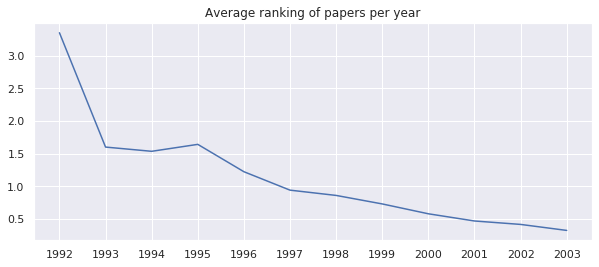

In [55]:
fig= plt.figure(figsize=(10,4))
plt.plot(year_avg_ranking['year'], year_avg_ranking['avg(pagerank)'])
plt.title('Average ranking of papers per year')
plt.show()

As expected, older papers have higher ranking that newer ones. This bias is caused by two factor:
- First, older paper tend to have more citations, which mechanically increases it's ranking
- Second, if a break through article cites a previous work, it will strongly propagate its own "importance" to older papers it has cited. 

We can see that the pick citations in the previous graphs has totally disapeared. A better way of doing this ranking would be to count the temporal component of those citations in the calculation of ranks.

# Clustering papers


## The Label Propagation algorithm

The lalbel propagation algorithm (Raghavan et al in 2007, "Near linear time algorithm to detect community structures in large-scale networks") is an iterative that propagates labels through a network to obtain communities of nodes. Using this algorithm will allow us to create cluster of papers belonging to the same "research process" or "research tree".

The LPA works as follow:
- Every node is initialized with a unique community label. 
- At every iteration of propagation, each node updates its label to the one that the maximum numbers of its neighbours belongs to. Ties are broken uniformly and randomly.
- LPA reaches convergence when each node has the majority label of its neighbours or reaches the max number of iterations allowed

First, we recreate our graph, this time we will make it undirected by adding edges corresponding to "is cited by" association.

In [56]:
del g

In [119]:
vertices = df_citations_2.select(['id', 'title'])

In [57]:
edges_to = lines.map(lambda x: (format_id(x.split('\t')[0]), format_id(x.split('\t')[1]), 'cite'))
edges_to = edges_to.toDF(['src', 'dst', 'type'])

In [58]:
edges_from = lines.map(lambda x: (format_id(x.split('\t')[1]), format_id(x.split('\t')[0]), 'is_cited'))
edges_from = edges_from.toDF(['src', 'dst', 'type'])

In [59]:
edges = edges_to.union(edges_from)

In [60]:
edges.show(2)

+-------+-------+----+
|    src|    dst|type|
+-------+-------+----+
|0001001|9304045|cite|
|0001001|9308122|cite|
+-------+-------+----+
only showing top 2 rows



In [61]:
del edges_to, edges_from

In [62]:
g = GraphFrame(vertices, edges)

In [63]:
g.edges.show(2)

+-------+-------+----+
|    src|    dst|type|
+-------+-------+----+
|0001001|9304045|cite|
|0001001|9308122|cite|
+-------+-------+----+
only showing top 2 rows



### Apply LPA

Launching the algorithm for 50 iteration doesn't guarantee covergence. Depending on your computer and spark configuration you might be able to launch it for more iterations. Considering, my limited ressources 50 iterations allow for a reasonnable execution time.

In [64]:
result_LPA = g.labelPropagation(maxIter=50)

In [119]:
result_LPA.show(2)

+-------+--------------------+-----+
|     id|               title|label|
+-------+--------------------+-----+
|0111249|Spectrum of Schro...|   26|
|0201199|On three dimensio...|   29|
+-------+--------------------+-----+
only showing top 2 rows



In [65]:
g.vertices.write.parquet("vertices_LPA_2")
g.edges.write.parquet("edges_LPA_2")

In [66]:
result_LPA.select(['id', 'label']).toPandas().to_csv('results_LPA')

In [128]:
result_LPA.rdd.getNumPartitions()

200

Number of detected cluster (i.e communities)

In [68]:
result_LPA.select('label').distinct().count()

890

In [86]:
df_citations_2 = df_citations_2.join(result_LPA.select(['id', 'label']), 'id')

In [87]:
df_citations_2.printSchema()

root
 |-- id: string (nullable = true)
 |-- cit_given: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- nb_cit_given: long (nullable = true)
 |-- cit_received: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- nb_cit_received: long (nullable = true)
 |-- title: string (nullable = true)
 |-- abstract: string (nullable = true)
 |-- year: string (nullable = true)
 |-- date: date (nullable = true)
 |-- pagerank: double (nullable = true)
 |-- label: long (nullable = true)



The number of obtained cluster is higher than expected. But still we will look to see if there is clusters containing a significant number of papers.

In [88]:
df_citations_2.groupBy('label').count().orderBy(F.desc('count')).show(10)

+-------------+-----+
|        label|count|
+-------------+-----+
|  17179869325|14930|
|1065151889414|  818|
| 231928234090|  506|
|1082331758644|  464|
| 463856468031|  347|
| 747324309543|  272|
| 807453851694|  254|
| 695784702044|  224|
|1005022347273|  216|
| 927712936010|  213|
+-------------+-----+
only showing top 10 rows



### Describing clusters
So some clusters seems to contain enough papers so that our analysis can be interesting. We are going to try to describe clusters by using the abstract of each paper in a group. To do so, we will simply process the abstract of all papers and apply a word count.

In [89]:
import string
import re

import nltk
from nltk.corpus import stopwords
stop_words=set(stopwords.words('english'))

In [90]:
def tokenize_text(t):
    #Remove punctuation and non alphanumerical
    t = t.translate(str.maketrans('','',string.punctuation))
    t = re.sub(r'([^\s\w]|_)+', '', t)
    #put all words in lower case
    t = t.lower()
    words = nltk.word_tokenize(t)
    
    return [word for word in words if not word in stop_words]

In [91]:
def list_to_dict(l):
    res={}
    keys=[]
    for w in l:
        if w in keys:
            res[w] += 1
        else:
            res[w] = 1
            keys.append(w)
    return res

In [92]:
def unionDict(dic1, dic2):
    keys = dic1.keys()
    for k in dic2.keys():
        if k in keys:
            dic1[k] += dic2[k]
        else:
            dic1[k] = dic2[k]
    return dic1

The initial idea was to use transform **unionDict()** as a **pandas_udf** aggregate function in order to return the word count of abstracts by label. Unfortunatly, **MapType** are not yet supported as returned value. 

https://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=agg#pyspark.sql.functions.pandas_udf

In [93]:
tokenize_udf = F.udf(tokenize_text, ArrayType(StringType()))
list_to_dict_udf = F.udf(list_to_dict, MapType(StringType(), DoubleType()))

In [94]:
df_citations_2 = df_citations_2.withColumn("abstract_tokenized", tokenize_udf(df_citations_2['abstract']))

In [95]:
df_citations_2 = df_citations_2.withColumn("abstract_dict", list_to_dict_udf(df_citations_2['abstract_tokenized']))

Instead we will perform the word count using the rdd representation of the data frame. We will first map the label and the tokenized abastract and then use reduce by key using **unionDict** as reduce function.

In [96]:
abstract_rdd = df_citations_2.select(['label', 'abstract_tokenized']).rdd

In [97]:
abstract_rdd_word_count = abstract_rdd.map(lambda x: (x[0], list_to_dict(x[1]))).reduceByKey(lambda x,y: unionDict(x,y))

In [98]:
abstract_word_count_df = abstract_rdd_word_count.toDF(['label', 'word_count']).toPandas()

In [99]:
label_df = df_citations_2.groupBy('label').count().toPandas()

In [100]:
label_df_word_count = label_df.set_index('label').join(abstract_word_count_df.set_index('label'))

In [101]:
pd.set_option('display.max_colwidth', -1)

/home/steve/anaconda3/envs/pyspark/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


In [102]:
label_df_word_count.nlargest(10, 'count')

,count,word_count
label,,
17179869325,14930,"{'unavailable': 3, 'marquard': 2, 'abrupt': 1, 'allscale': 1, 'kinfty': 2, 'superworldvolume': 2, '362d': 2, 'cubically': 1, '0alpha1': 1, 'instantonmeron': 1, 'truncates': 1, 'quartets': 1, 'o5sp4': 1, 'spreading': 7, 'winftygravity': 3, 'superanalysis': 1, 'carriers': 2, 'phenomenologically': 45, 'calderbank': 3, '0': 386, '1': 622, 'noncomutative': 1, '2': 582, '3': 309, '4': 409, '5': 137, '6': 142, 'kallenlehmann': 1, '7': 66, '8': 136, 'complexifiedcotangent': 1, '9': 36, 'discretisations': 2, '1000': 2, 'equivariantly': 2, 'result': 1101, 'spaceorientable': 1, 'reprodued': 1, 'evaporate': 6, 'flip': 14, 'imbedded': 5, 'staircase': 1, 'resume': 2, 'b': 324, 'c': 211, 'garland': 2, 'collisions': 17, 'sinhgordon': 7, 'e': 103, 'f': 220, 'g': 508, 'h': 213, '1011': 3, 'truncated': 58, '1010': 4, 'j': 71, 'k': 341, 'so3xso3': 2, 'l': 111, 'eating': 2, 'n': 1685, 'reconfirmed': 1, 'p': 292, 'q': 207, 'r': 330, 'u': 88, 'cbundles': 2, 'v': 96, 'qpsi0': 1, 'w': 125, 'x': 1010, 'hyperkahler': 154, 'information': 238, 'z': 148, 'goldstone': 91, 'dp1index': 1, '1020': 3, 'reproduce': 180, '1019': 2, 'u4r9': 1, 'nonregular': 3, '1018': 2, '1017': 3, '1016': 13, '1015': 2, 'wyllard': 1, '1014': 5, 'suffered': 1, '1012': 5, 'besides': 67, 'irrelevancy': 1, '3692': 1, 'nfgeq': 3, 'eguchihansongibbons': 1, '1033': 3, '1032': 1, 'violationconservation': 1, '1030': 1, 'criterions': 1, 'wigner': 34, ...}"
1065151889414,818,"{'cancel': 9, 'half': 1, 'dimopoulos': 2, 'interacting': 10, 'einsteins': 35, 'spontaneous': 15, 'equations': 237, 'imperfect': 2, 'diverges': 3, 'would': 34, 'electronically': 1, 'combinatorial': 2, 'ten': 3, '2forms': 1, 'energy': 228, 'conceal': 1, 'destabilizes': 1, 'successfully': 1, 'solid': 6, 'matterquantum': 1, 'tev': 25, 'meanwhile': 1, 'vbulk': 1, 'righthanded': 1, 'factorized': 1, 'reenter': 2, 'coincide': 4, 'require': 8, 'onbrane': 6, 'd5brane': 3, 'hartlehawking': 1, 'phenomenologically': 3, '0': 28, 'nuinfty': 1, 'stabilized': 19, 'solitonic': 13, 'invacuum': 2, '1': 35, '2': 31, 'pbranes': 14, 'momentumspace': 1, '3': 16, 'size': 53, '4': 13, 'applies': 2, '5': 12, 'left': 1, '6': 5, 'kallenlehmann': 1, '7': 1, 'generalizing': 5, 'squared': 4, 'extracts': 1, 'eleven': 2, 'densities': 12, 'object': 11, 'largescale': 3, 'accessible': 1, 'statistical': 11, 'role': 33, 'infinite': 37, '1000': 1, 'notable': 1, 'turn': 9, 'walds': 1, 'example': 32, 'paradigmatic': 1, 'result': 62, 'zannias': 1, 'ttoinfty': 1, 'luminosity': 2, '1997ff': 1, 'imbedded': 1, 'connect': 2, 'modulus': 9, 'hand': 13, 'combinatorics': 1, 'ordered': 1, 'b': 8, 'c': 14, 'address': 13, 'collisions': 2, 'sinhgordon': 1, 'e': 5, 'tabletop': 3, 'g': 3, 'h': 13, '3position': 1, 'truncated': 3, 'k': 12, 'pointlike': 2, 'l': 26, 'obeying': 2, 'violating': 3, 'linewidth': 1, 'n': 30, 'cft': 49, 'p': 4, 'straight': 2, 'q': 3, ...}"
231928234090,506,"{'cancel': 11, 'half': 4, 'interacting': 32, 'intrinsically': 1, 'grouptheoretic': 1, 'spontaneous': 8, 'einsteins': 1, 'borchers': 2, 'equations': 77, 'noncoincident': 1, 'singletrace': 7, 'osp12n': 1, 'would': 5, 'renormalizing': 6, 'truncates': 1, 'combinatorial': 1, 'ten': 1, 'energy': 76, 'wiesbrock': 1, 'successfully': 2, 'solid': 1, 'factorized': 1, 'notably': 1, 'uncountably': 1, 'coincide': 6, 'require': 6, 'circular': 12, 'hartlehawking': 1, 'd5brane': 2, 'nonfrozen': 1, '0': 11, 'solitonic': 1, '1': 16, '2': 31, '3': 15, 'size': 8, '4': 33, 'applies': 5, 'triple': 2, '5': 3, 'left': 2, '6': 5, '7': 2, '8': 6, '9': 1, 'squared': 2, 'generalizing': 1, 'eleven': 1, 'densities': 3, 'object': 1, 'accessible': 2, 'statistical': 4, 'role': 16, 'infinite': 33, 'weil': 1, 'cek': 1, '1000': 1, 'turn': 9, 'psu224': 2, 'supercurrents': 1, 'example': 24, 'paradigmatic': 1, 'result': 55, 'translationinvariant': 1, 'spanning': 2, '3point': 13, '11dimensional': 1, 'rational': 9, 'modulus': 1, 'connect': 1, 'hand': 7, 'combinatorics': 4, 'b': 7, 'c': 42, 'addre

The results are hard to interpret as the word count is not the best way of extracting key words form a document. A possible amelioration would be to use technics such as the **Term frequency-inverse document frequency** statistics to extract key words from abstract.

## Visualizing the network

To visualize the graph of papers we have to use regular python, this is why this part might not be suited to use on a bigger dataset. We use networkx to diplay a sub graph of our graph of papers. The original graph would have too many nodes to be clearly visible using networkx (softaware such as Gephi are more adapted). We color the three biggest cluster using blue, orange and red, all other nodes are in Yellow.

In [118]:
import networkx as nx

In [ ]:
nodes_label_pd = df_citations_2.select(['id', 'label']).toPandas()

In [153]:
color_mapping = {'17179869325':'blue', '1065151889514':'orange', '231928234090':'red'}

In [154]:
def PlotGraph(edge_list):
    Gplot=nx.Graph()
    for row in edge_list.select('src','dst').take(5000):
        Gplot.add_edge(row['src'],row['dst'])
    cmap=[]
    for node in list(Gplot.nodes):
        label = str(nodes_label_pd[nodes_label_pd.id==node]['label'].values[0])
        if label in color_mapping.keys():
            cmap.append(color_mapping[label])
        else:
            cmap.append('yellow')

    nx.draw(Gplot, node_size=10, width=0.5, node_color=cmap, alpha=0.5)

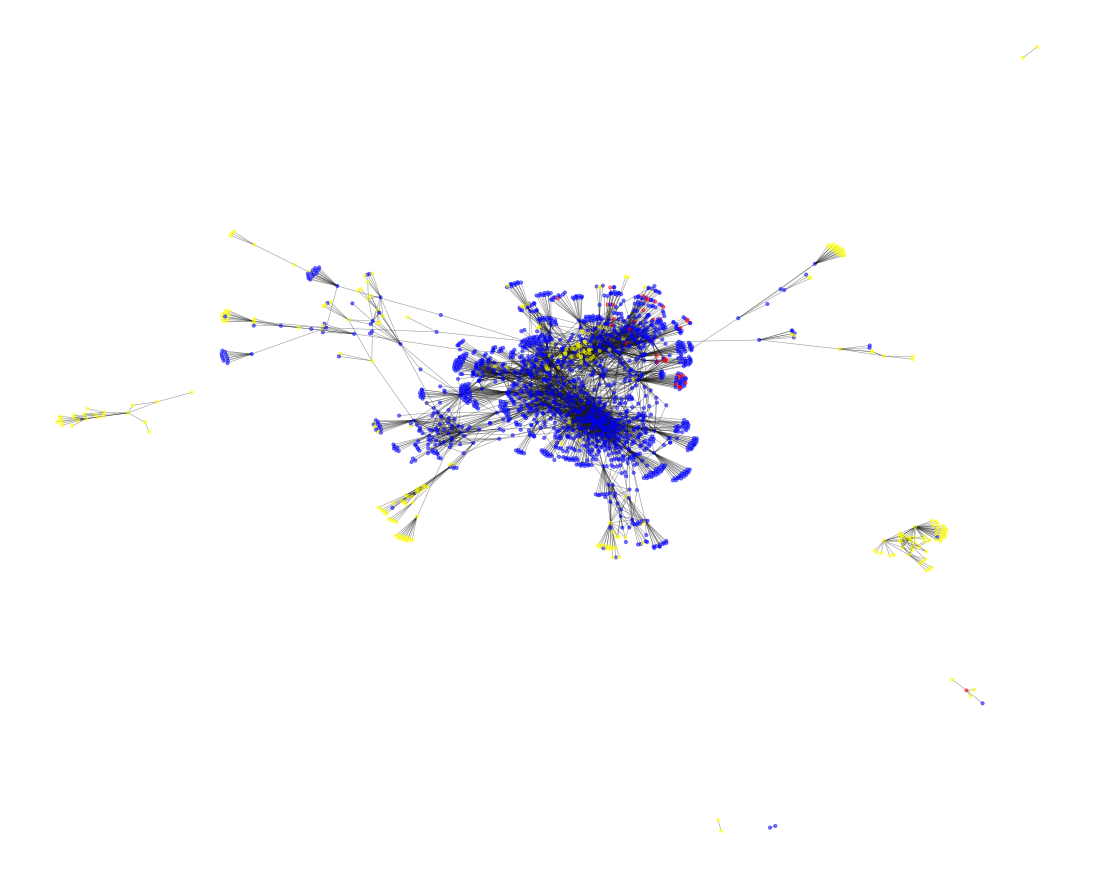

In [155]:
plt.figure(figsize=(15,12))
PlotGraph(g.edges)